In [2]:
# torch related imports
import torch
from lightning.pytorch.loggers import TensorBoardLogger

# imports for hyperparam tuning with Ray
from ray import tune
from ray.train.torch import TorchTrainer
from ray.train import RunConfig, ScalingConfig, CheckpointConfig

# Lightning
import lightning as L

from utils import loadData, plotExamples, set_reproducibility
from models import train_func, tuning, ConvNet, Classificator

## Hyperparameters

In [ ]:
#Dataloader params
NUM_WORKERS = 7 # 7 because that what it suggested in a warning message
PERSISTENT_WORKERS = True # Suggested to do this in a warning message for faster init
USE_AUGMENT = False  # mutual exclusive with CUSTOM_TRAIN_VAL_SPLIT
CUSTOM_TRAIN_VAL_SPLIT = True  # mutual exclusive with USE_AUGMENT
DATA_DIR = "chest_xray" # Change this to chest_xray folder
USE_SAMPLER = False
SHOW_ANALYTICS = False

# Lightning moduls params
EPOCHS = 50
CLASS_LABELS = ["Normal", "Pneumonia"]
NUM_CLASSES = 2

# Tuning params
NUM_SAMPLES = 20 # Number of sampls from parameter space

search_space = {
    "reproducibility_active": True,
    "epochs": EPOCHS,
    #"seed": tune.randint(0, 10000),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([4, 16,32, 64]),
    "loss" : tune.choice(["BCEwLogits", "CrossEntropyLoss"]),
    "dropout": tune.choice([0.2, 0.5, 0.8]), # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10518240/pdf/cureus-0015-00000044130.pdf
}

## Ensuring reporducibility

In [3]:
# Setting the seed
set_reproducibility(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


## Load Data and show Analytics

Size of train dataset: 4186
Size of validation dataset: 1046
Size of test dataset: 624


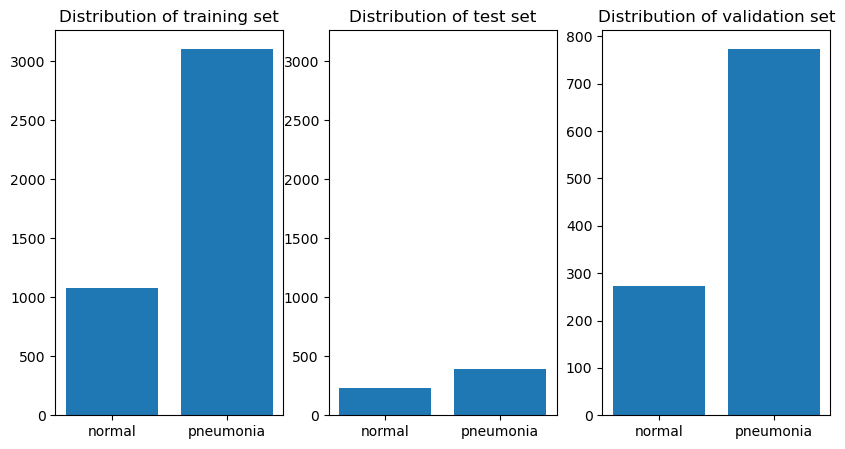

In [4]:
# show analytics
train_loader, val_loader, test_loader = loadData(numWorkers=NUM_WORKERS, showAnalytics = True, batchSize = 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


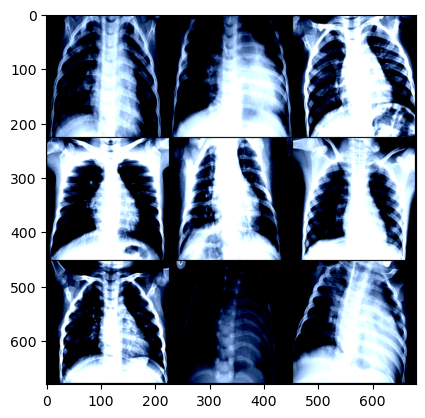

In [4]:
plotExamples(train_loader)

## Hyperparameter Tuning with Ray Tune

In [47]:
# setting scaling and run config
scaling_config = ScalingConfig(
    num_workers=2, use_gpu=True
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=2,
        checkpoint_score_attribute="val_BinaryAccuracy",
        checkpoint_score_order="max",
    ),
)

In [48]:
# Define a TorchTrainer without hyper-parameters for Tuner
ray_trainer = TorchTrainer(
    train_func,
    scaling_config=scaling_config,
    run_config=run_config,
)

In [49]:
results = tuning(ray_trainer, search_space, num_samples=NUM_SAMPLES, num_epochs=EPOCHS)

2024-05-13 10:58:40,920	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. No trial is running and no new trial has been started within the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 1.0 CPUs and 2.0 GPUs per trial, but the cluster only has 64.0 CPUs and 1.0 GPUs available. Stop the tuning and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.
2024-05-13 10:59:12,139	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-05-13 10:59:12,146	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is 

In [ ]:
best_result = results.get_best_result(metric="val_BinaryAccuracy", mode="max")
best_config = best_result.config  # Get best trial's hyperparameters
print(best_config)
#best_logdir = best_result.path  # Get best trial's result directory
#best_checkpoint = best_result.checkpoint  # Get best trial's best checkpoint
best_metrics = best_result.metrics  # Get best trial's last results
print(best_metrics)
best_result_df = best_result.metrics_dataframe  # Get best result as pandas dataframe

## Running a CNN with the best found hyperparams

In [ ]:
early_stopping = L.pytorch.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-6)
checkpoint = L.pytorch.callbacks.ModelCheckpoint(dirpath='pneumonia_model/', monitor="val_BinaryAccuracy", mode='max')
callbacks = [early_stopping, checkpoint]
logger = TensorBoardLogger("lightning_logs",
                           name=f"simpleCNN/{'augment' if USE_AUGMENT else 'original'}",
                           )

In [ ]:
trainer = L.Trainer(
    accelerator = 'auto',
    devices=1,
    logger=logger,
    max_epochs=EPOCHS, 
    callbacks=callbacks)

In [ ]:
cnn = ConvNet(num_classes=2, dropout=best_config['train_loop_config']['dropout'])
classifier = Classificator(cnn, CLASS_LABELS, best_config['train_loop_config'], NUM_CLASSES)
torch.set_float32_matmul_precision('medium')
trainer.fit(classifier,train_dataloaders=train_loader,val_dataloaders=val_loader)

In [ ]:
#{'train_loop_config': {'seed': 7270, 'lr': 0.024526126311336764, 'batch_size': 4, 'loss': 'BCEwLogits', 'dropout': 0.2}}

## Testing final Model

In [ ]:
#trainer.test(model = cnn, dataloaders=test_loader)